In [51]:
%matplotlib inline
import everest
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.constants import R_sun, R_earth
import astropy.units as u
from robin import TransitModel, TransitModel

In [52]:
zeit = Table.read('data/zeit.csv')

In [53]:
duration = 0.033

In [54]:
zeit[0]

EPIC,per,rp,t0,inc,ecc,w,a,mstar,mstar_err,rstar,rstar_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
210490365,3.484552,0.1065,2457062.57935,88.3,0.27,62.0,20.225,0.294,0.021,0.295,0.02


In [55]:
params = TransitParams()

for attr in zeit[0].colnames: 
    setattr(params, attr, zeit[0][attr])
    
params.duration = duration

params.limb_dark = 'quadratic'
params.u = [0., 0.]
params.p0 = params.rp
params.p1 = params.rp

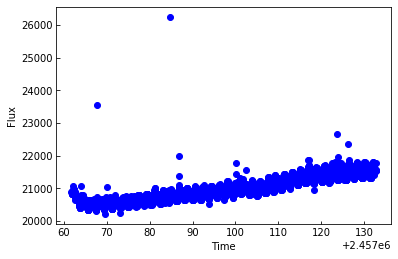

In [56]:
from toolkit import LightCurve

t, f = np.load('data/210490365.npy')

lc = LightCurve(t + 2454833, f)
lc.plot()

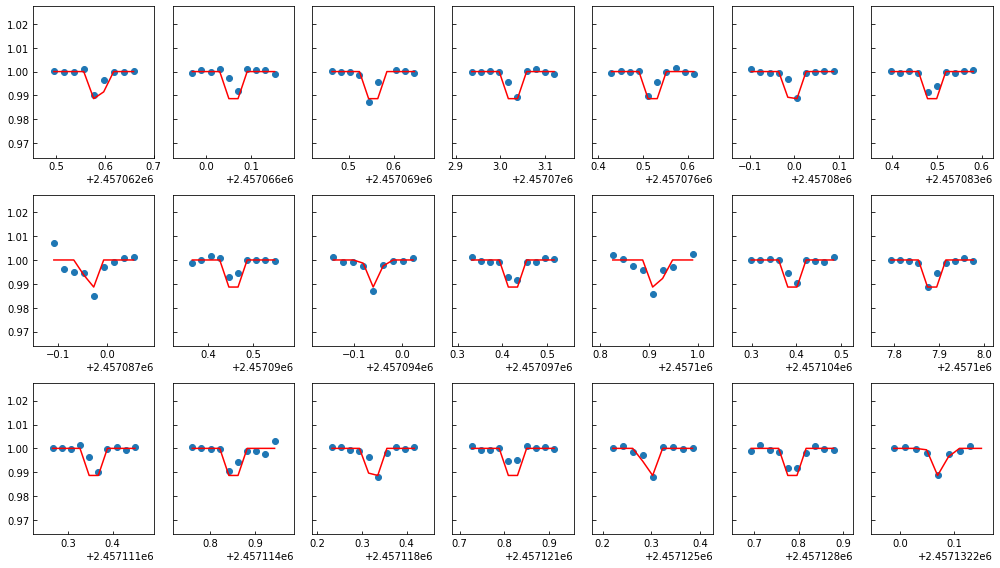

In [57]:
mask_oot = lc.mask_out_of_transit(params, oot_duration_fraction=2.5)
transits = LightCurve(**mask_oot).get_transit_light_curves(params)

fig, ax = plt.subplots(3, 7, figsize=(14, 8), sharey=True)

times = []
fluxes = []
for i, transit in enumerate(transits): 
    transit.remove_linear_baseline(params, cadence=30*u.min)
    ax[i//7, i % 7].scatter(transit.times.jd, transit.fluxes)

    m = TransitModel(params, transit.times.jd, exp_time=0.5/24)
    model = m.light_curve(params)
    
    ax[i//7, i % 7].plot(transit.times.jd, model, color='r')
    
    times.extend(transit.times.jd)
    fluxes.extend(transit.fluxes)
    
times = np.array(times)
fluxes = np.array(fluxes)
fig.tight_layout()

In [58]:
phased_times = ((times - params.t0) % params.per)
phased_times[phased_times > params.per/2] -= params.per

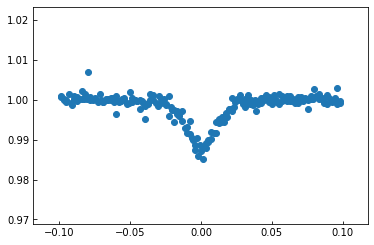

In [59]:
plt.scatter(phased_times, fluxes)

In [61]:
from copy import deepcopy
import emcee

def transit_model(p, times): 
    p0, p1, inc, a, u1, u2 = p
    trial_params = deepcopy(params)
    trial_params.p0 = p0
    trial_params.p1 = p1
    trial_params.inc = inc
    trial_params.a = a
    trial_params.t0 = 0
    trial_params.u = [u1, u2]
    
    m = TransitModel(trial_params, times, exp_time=0.5/24, supersample_factor=3)
    return m.light_curve(trial_params)

def lnprior(p):
    p0, p1, inc, a, u1, u2 = p
    
    if ((p0 < 0) or (p1 < 0) or (inc > 90) or (u1 < -1) or (p0 > 1) or (p1 > 1) or 
        (u1 > 1) or (u2 < -1) or (u2 > 1) or (a < 1)):
        return -np.inf
    return 0

def lnlike(p, times, fluxes, ferr): 
    p0, p1, inc, a, u1, u2 = p

    lp = lnprior(p)
    if np.isfinite(lp): 
        return -0.5 * np.nansum((transit_model(p, times) - fluxes)**2 / ferr**2) + lp
    return -np.inf

ndim = 6
nwalkers = 2 * ndim

ferr = np.nanstd(fluxes[(phased_times < -params.duration) | (phased_times > params.duration)])

<ErrorbarContainer object of 3 artists>

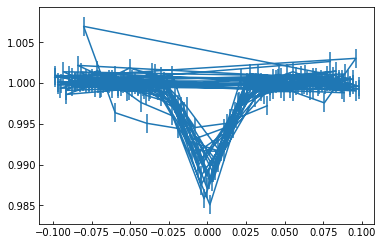

In [66]:
plt.errorbar(phased_times, fluxes, ferr*np.ones_like(fluxes))

In [62]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(phased_times, fluxes, ferr), 
                               threads=8)

p0 = [1e-5 * np.random.randn(ndim) + 
      np.array([params.p0, params.p1, params.inc, params.a, params.u[0], params.u[1]])
      for i in range(nwalkers)]

p1 = sampler.run_mcmc(p0, 5000)[0]
sampler.reset()
sampler.run_mcmc(p1, 10000)
sampler.pool.close()

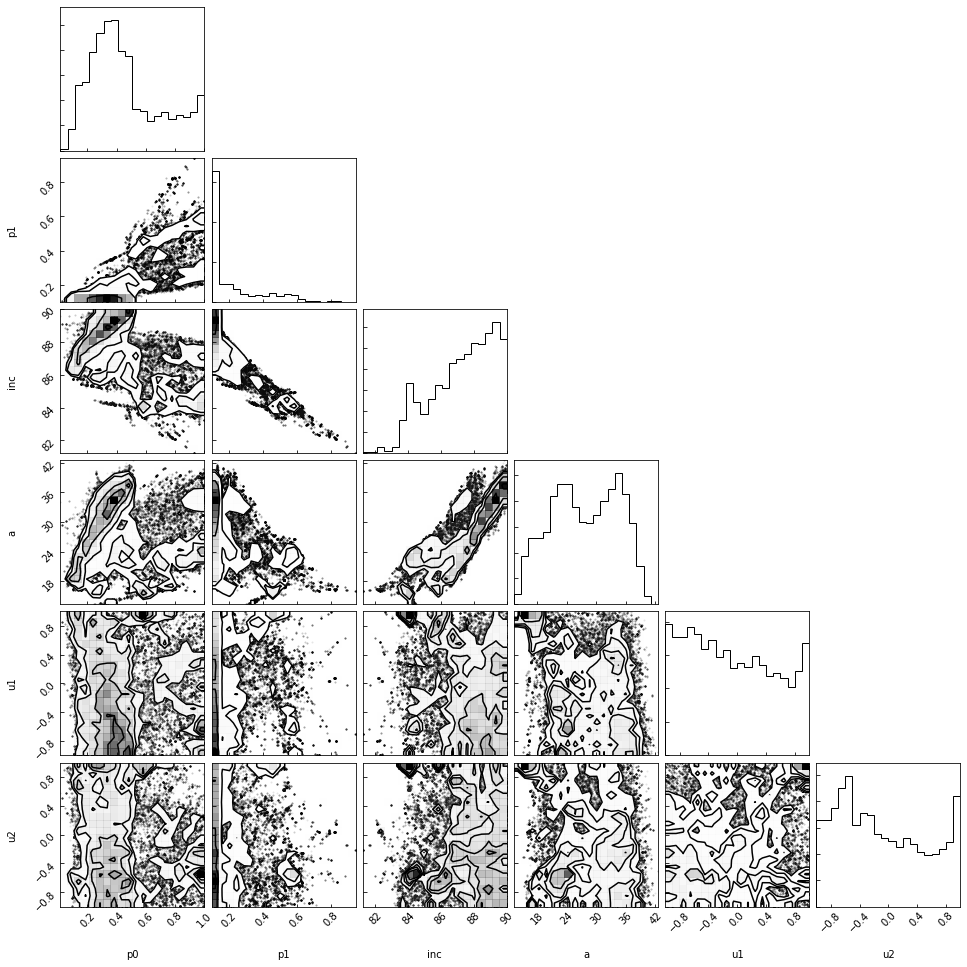

In [64]:
from corner import corner
corner(sampler.flatchain, labels='p0, p1, inc, a, u1, u2'.split(', '));

(array([  7.45860000e+04,   1.52370000e+04,   6.98700000e+03,
          6.45200000e+03,   7.22500000e+03,   7.12500000e+03,
          1.55500000e+03,   3.08000000e+02,   4.59000000e+02,
          6.60000000e+01]),
 array([ 0.09925879,  0.1837766 ,  0.2682944 ,  0.35281221,  0.43733002,
         0.52184783,  0.60636564,  0.69088345,  0.77540125,  0.85991906,
         0.94443687]),
 <a list of 1 Patch objects>)

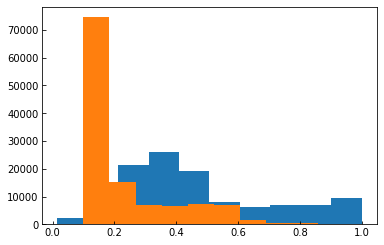

In [65]:
plt.hist(sampler.flatchain[:, 0], histtype='stepfilled')
plt.hist(sampler.flatchain[:, 1], histtype='stepfilled')